<a href="https://colab.research.google.com/github/briceshun/sm_contagion/blob/Visualisation/ContagionModels_FTX_Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install `libncurses`

In [ ]:
!apt-get install libncurses5

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libncurses5 is already the newest version (6.3-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
# Restart runtime after install
import os
os.kill(os.getpid(), 9)

# Install Required Packages

In [ ]:
!pip install -q tellurium==2.2.8

In [ ]:
!pip install import-ipynb seaborn lmfit

---
# Import Packages

In [ ]:
# Google Drive
from google.colab import drive
drive.mount("mnt", force_remount=True)

# Data Cleaning
from datetime import datetime, timedelta
import json
import os
import numpy as np
import pandas as pd

# Modelling
import lmfit
import tellurium as te

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at mnt


In [ ]:
%cd "mnt/Shareddrives/ECIS2024_CM"

/content/mnt/Shareddrives/ECIS2024_CM


In [ ]:
# Import Functions from Other NB
import import_ipynb
from ContagionModels_Utils import noOutlier, emotionGroup, describeEvent, plotLine, plotStack

importing Jupyter notebook from ContagionModels_Utils.ipynb


---
# 1. Load Data

In [ ]:
# Videos
with open('ftx/ftx_videos.json', "r") as f:
  videos = json.loads(f.read())
keys = list(videos['videos'][0].keys())
df_videos = pd.DataFrame.from_dict({k:[x[k] for x in videos['videos'] if x != 'No videos'] for k in keys})

In [ ]:
# Stats
with open('ftx/ftx_stats.json', "r") as f:
  stats = json.loads(f.read())
keys = list(stats[0].keys())
dict = {k:[] for k in keys}
for k in keys:
    x = []
    for i in stats:
        try:
            dict[k].append(i[k])
        except:
            dict[k].append(np.nan)
df_stats = pd.DataFrame.from_dict(dict)
df_stats.fillna(0, inplace=True)
for col in ['viewCount', 'likeCount', 'favoriteCount', 'commentCount']:
    df_stats[col] = df_stats[col].astype(int)

In [ ]:
# Comments
comments = []
for i in [x for x in os.listdir('ftx') if x.split('_')[1] not in ['videos.json', 'stats.json']]:
    with open('ftx/'+i, "r") as f:
      comments += json.loads(f.read())
keys = list(comments[0].keys())
df_comments = pd.DataFrame.from_dict({k:[x[k] for x in comments] for k in keys})

---
# 2. Transform Data

In [ ]:
# Group emotions
df_comments['emotionraw'] = df_comments['emotion']
df_comments['emotion'] = df_comments['emotionraw'].apply(lambda x: emotionGroup(x))
df_comments['valence'] = df_comments['emotionraw'].apply(lambda x: emotionGroup(x, valence=True))

In [ ]:
# Add dates to stats
df_vid_stats = df_videos.merge(df_stats, how='left', left_on='videoId', right_on='id')
df_vid_stats = noOutlier(df_vid_stats, ['viewCount', 'likeCount', 'commentCount'])

# Describe
desc_vid_stats = describeEvent(df_vid_stats, ['viewCount', 'likeCount', 'commentCount'])
desc_vid_stats

,index,viewCount,likeCount,commentCount
0,count,6.918000e+03,6.918000e+03,6918.000000
1,mean,2.327563e+04,6.329299e+02,141.596560
2,std,5.211830e+04,1.473919e+03,260.615481
3,var,2.716318e+09,2.172437e+06,67920.428943
4,min,0.000000e+00,0.000000e+00,0.000000
5,max,7.365660e+05,1.074100e+04,1570.000000


In [ ]:
# Describe
df_describe = describeEvent(df_vid_stats, ['viewCount', 'likeCount', 'commentCount'], func = ['count', 'mean', 'std', 'var', 'min', 'max', 'sum'])
df_describe

,index,viewCount,likeCount,commentCount
0,count,6.918000e+03,6.918000e+03,6918.000000
1,mean,2.327563e+04,6.329299e+02,141.596560
2,std,5.211830e+04,1.473919e+03,260.615481
3,var,2.716318e+09,2.172437e+06,67920.428943
4,min,0.000000e+00,0.000000e+00,0.000000
5,max,7.365660e+05,1.074100e+04,1570.000000
6,sum,1.610208e+08,4.378609e+06,979565.000000


In [ ]:
# Convert columns
df_vid_stats['publishedAt']= pd.to_datetime(df_vid_stats['publishedAt'])
df_vid_stats['date'] = df_vid_stats['publishedAt'].dt.date

for col in ['viewCount', 'likeCount', 'favoriteCount', 'commentCount']:
    df_vid_stats[col] = pd.to_numeric(df_vid_stats[col])

In [ ]:
# Group and summarise
df_vid_stats_date = df_vid_stats.groupby('date')\
                                .agg(   viewSum=('viewCount', 'sum'),
                                        likeSum=('likeCount', 'sum'),
                                        favoriteSum=('favoriteCount', 'sum'),
                                        commentSum=('commentCount', 'sum'),
                                        viewAvg=('viewCount', 'mean'),
                                        likeAvg=('likeCount', 'mean'),
                                        favoriteAvg=('favoriteCount', 'mean'),
                                        commentAvg=('commentCount', 'mean'),
                                )\
                                .reset_index()

In [ ]:
# Convert columns
df_comments['publishedAt']= pd.to_datetime(df_comments['publishedAt'])
df_comments['date'] = df_comments['publishedAt'].dt.date

# Restrict date range
df_comments_ori = df_comments
df_comments = df_comments[df_comments['date'] >= datetime.strptime('2022-11-02', '%Y-%m-%d').date()]

In [ ]:
df_comments[~df_comments['emotion'].isin(['Neutral', 'error'])].groupby('emotion').agg(count=('commentid', 'count')).sort_values(by='count', ascending=False).T

emotion,Happiness,Affection,Fear,Satisfaction,Anger,Depression,Contempt
count,43909,42415,37240,33514,27409,9988,7290


In [ ]:
df_emo_date = df_comments.groupby(['emotion', 'date']).agg(n=('commentid', 'count')).reset_index()
df_emo_date[~df_emo_date['emotion'].isin(['Neutral', 'error'])]\
          .groupby(['emotion'])\
          .agg( avg=('n', 'mean'),
                sd=('n', np.std),
                min=('n', 'min'),
                max=('n', 'max')
              )\
          .reset_index()\
          .T

,0,1,2,3,4,5,6
emotion,Affection,Anger,Contempt,Depression,Fear,Happiness,Satisfaction
avg,573.175676,375.465753,102.676056,138.722222,490.0,577.75,459.09589
sd,306.285405,191.585351,52.304814,87.7983,293.38398,315.26713,223.058485
min,2,2,2,1,2,2,2
max,1519,778,223,565,1542,1392,1134


---
# 3. Initial Visualisation

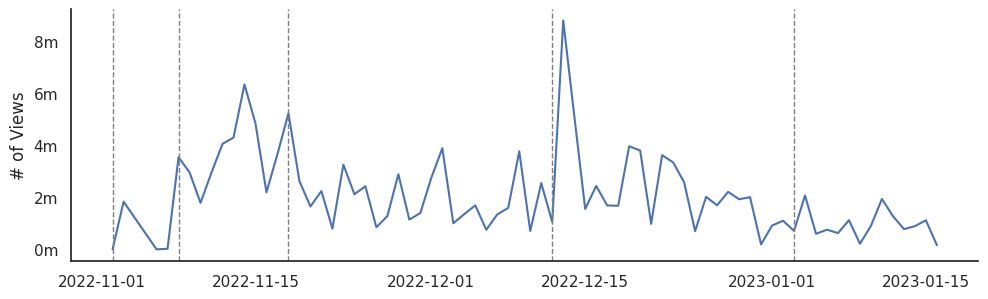

In [ ]:
# Plot total views each day
period = ['2022-11-02', '2023-01-30']
df_subset = df_vid_stats_date[(df_vid_stats_date['date'] >= datetime.strptime(period[0], '%Y-%m-%d').date())
                & (df_vid_stats_date['date'] <= datetime.strptime(period[1], '%Y-%m-%d').date())]

# Create plot
sns.set(rc={'figure.figsize':(11.7,3.27)})
sns.set_style(style='white')
plot = sns.lineplot(x='date', y='viewSum', data=df_subset)
# Formatting
# x-axis
plot.set(xlabel=None)
# y-axis
plot.set(ylabel='# of Views')
plot.yaxis.set_major_formatter(lambda y, p: f'{y/1000000:,.0f}m')
# Borders
sns.despine(bottom = False, left = False, top = True, right = True)

# Markers
# NOV. 2, 2022 - CoinDesk
plt.axvline(datetime.strptime('2022-11-02', '%Y-%m-%d').date(), 0,1, linestyle='--', linewidth=1, color='grey')
# NOV. 8, 2022 - Mass withdrawals
plt.axvline(datetime.strptime('2022-11-08', '%Y-%m-%d').date(), 0,1, linestyle='--', linewidth=1, color='grey')
# NOV. 18, 2022 - Assets seized
plt.axvline(datetime.strptime('2022-11-18', '%Y-%m-%d').date(), 0,1, linestyle='--', linewidth=1, color='grey')
# DEC. 12, 2022 - SBF arrested
plt.axvline(datetime.strptime('2022-12-12', '%Y-%m-%d').date(), 0,1, linestyle='--', linewidth=1, color='grey')
# Jan. 3, 2023 - SBF pleads not guilty
plt.axvline(datetime.strptime('2023-01-3', '%Y-%m-%d').date(), 0,1, linestyle='--', linewidth=1, color='grey')

sns.reset_orig()
# sns.set_style(style='white')

<Axes: ylabel='Total # of Comments'>

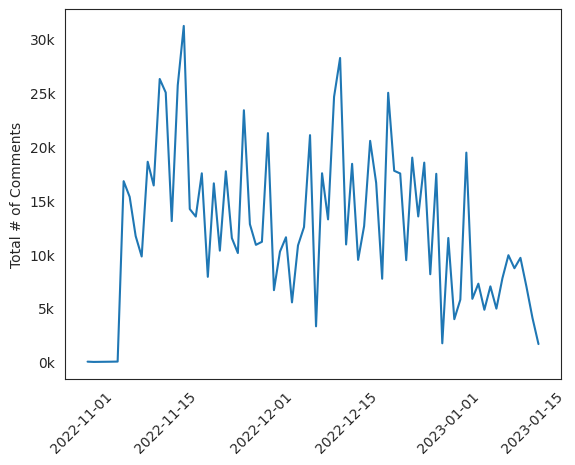

In [ ]:
# Plot total comments each day
plotLine(df_vid_stats_date, 'commentSum', ['2022-11-02', '2023-01-30'])

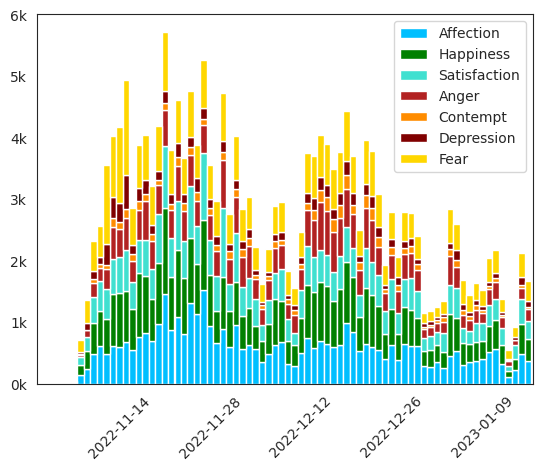

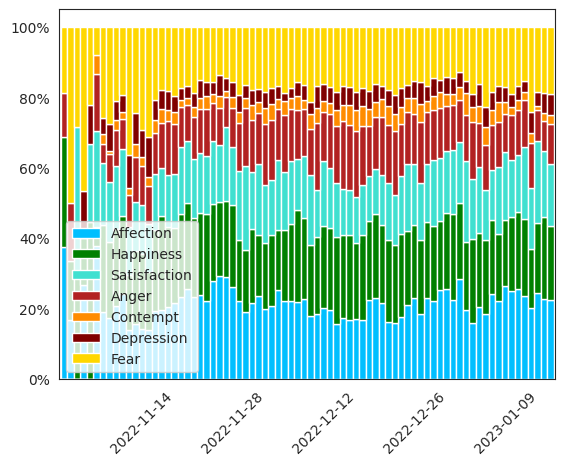

In [ ]:
# Summarise comment emotions
df_comments_emotion, df_comments_emotion100 = plotStack(df_comments, ['2022-11-01', '2023-01-30'])

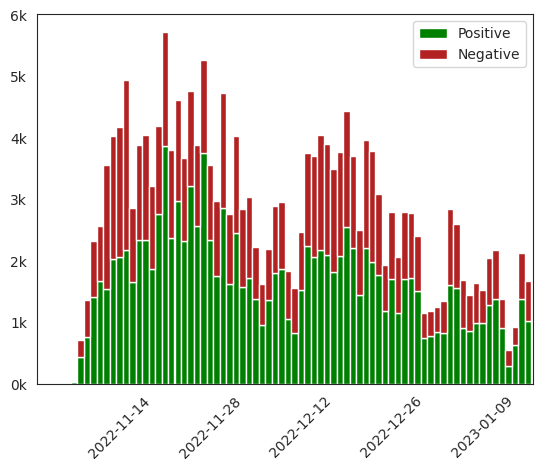

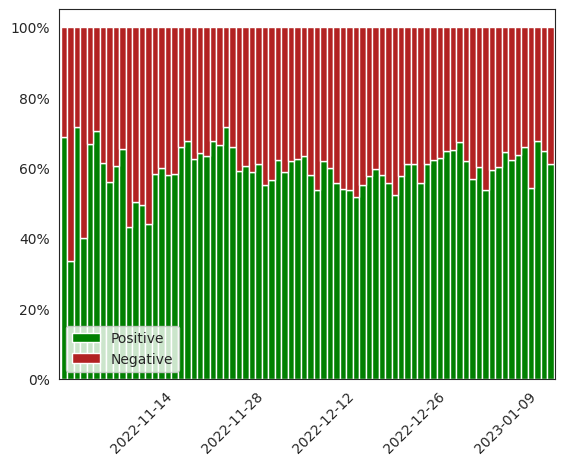

In [ ]:
# Summarise comment valence
df_comments_valence, df_comments_valence100 = plotStack(df_comments, ['2022-11-01', '2023-01-30'], valence=True)

<ipython-input-19-ae05a99738f9>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



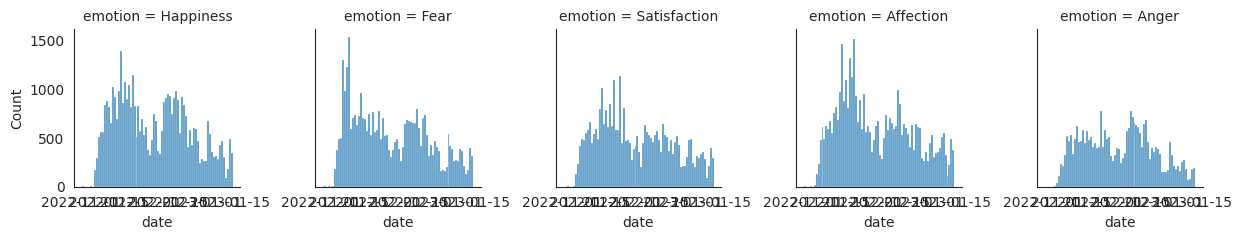

In [ ]:
df_comments_emoclean = df_comments[~df_comments["emotion"].isin(["Neutral", "error"])]
g = sns.FacetGrid(df_comments_emoclean[df_comments["emotion"].isin(["Affection", "Happiness", "Fear", "Satisfaction", "Anger"])],
                  col="emotion", height=2.5
                  )
g.map_dataframe(sns.histplot, x="date")

<ipython-input-20-5fa212ce04a7>:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



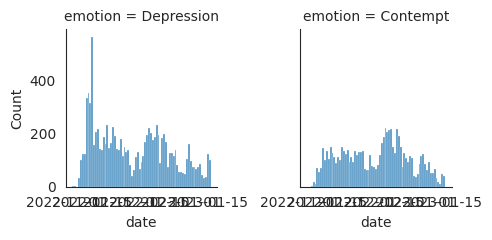

In [ ]:
g = sns.FacetGrid(df_comments_emoclean[df_comments["emotion"].isin(["Contempt", "Depression"])],
                  col="emotion", height=2.5
                  )
g.map_dataframe(sns.histplot, x="date")

<ipython-input-21-cab2fe2d674e>:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



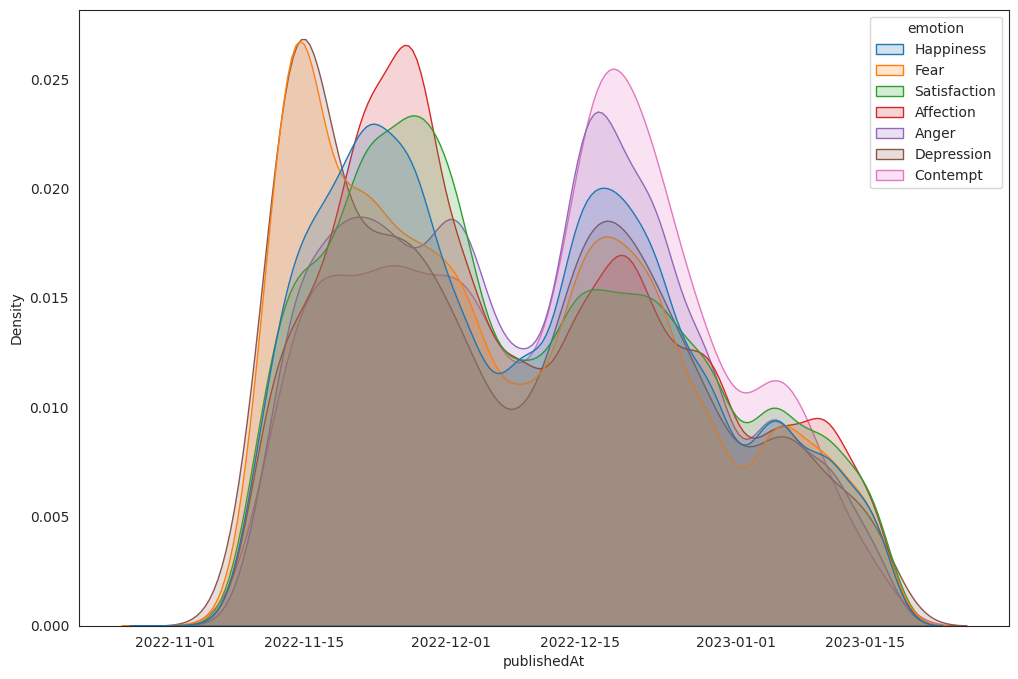

In [ ]:
# Set figure size for the notebook
plt.rcParams["figure.figsize"]=12,8

# With transparency
sns.kdeplot(data=df_comments_emoclean[df_comments["emotion"].isin(["Affection", "Anger", "Happiness", "Fear", "Satisfaction", "Contempt", "Depression"])],
            x="publishedAt", hue="emotion",
            fill=True, common_norm=False, alpha=0.2)
plt.show()

<ipython-input-22-a53681973f0c>:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



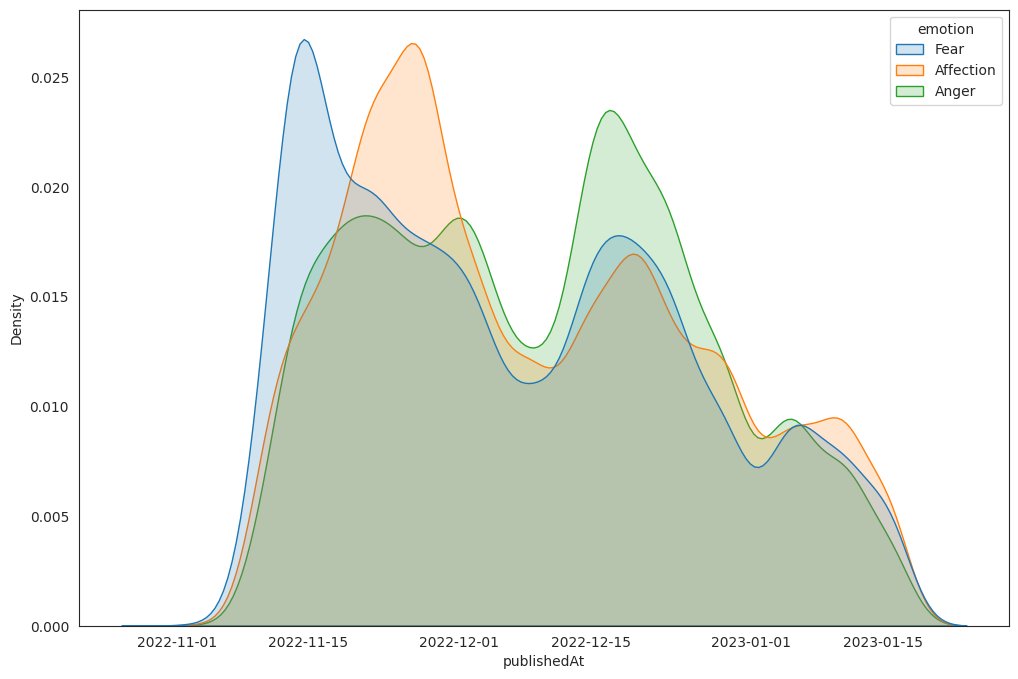

In [ ]:
# Set figure size for the notebook
plt.rcParams["figure.figsize"]=12,8

# With transparency
sns.kdeplot(data=df_comments_emoclean[df_comments["emotion"].isin(["Affection", "Anger", "Fear"])],
            x="publishedAt", hue="emotion",
            fill=True, common_norm=False, alpha=0.2)
plt.show()

---
# 4. Dataset & Function Creation

## 4.1. Dataset Creation

In [ ]:
df_affection    = df_comments_emoclean[df_comments_emoclean['emotion']=="Affection"].groupby('date').agg(count=('commentid', 'count')).reset_index()
df_anger        = df_comments_emoclean[df_comments_emoclean['emotion']=="Anger"].groupby('date').agg(count=('commentid', 'count')).reset_index()
df_contempt     = df_comments_emoclean[df_comments_emoclean['emotion']=="Contempt"].groupby('date').agg(count=('commentid', 'count')).reset_index()
df_depression   = df_comments_emoclean[df_comments_emoclean['emotion']=="Depression"].groupby('date').agg(count=('commentid', 'count')).reset_index()
df_fear         = df_comments_emoclean[df_comments_emoclean['emotion']=="Fear"].groupby('date').agg(count=('commentid', 'count')).reset_index()
df_happiness    = df_comments_emoclean[df_comments_emoclean['emotion']=="Happiness"].groupby('date').agg(count=('commentid', 'count')).reset_index()
df_satisfaction = df_comments_emoclean[df_comments_emoclean['emotion']=="Satisfaction"].groupby('date').agg(count=('commentid', 'count')).reset_index()

<ipython-input-24-b25f469c46cf>:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



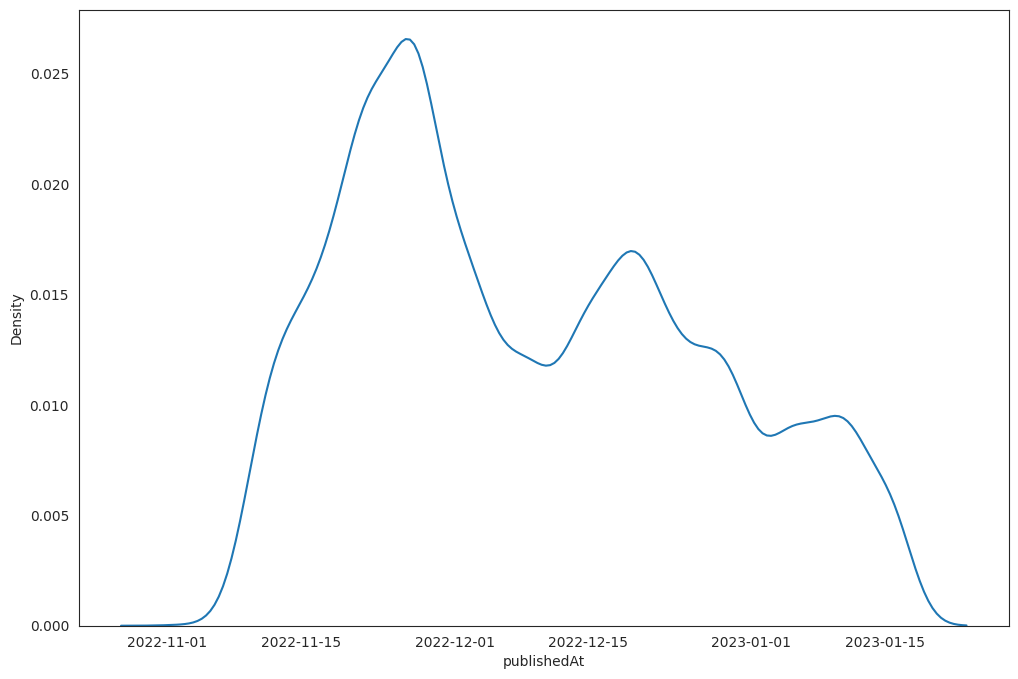

In [ ]:
my_kde = sns.kdeplot(data=df_comments_emoclean[df_comments["emotion"]=="Affection"], x="publishedAt")
line = my_kde.lines[0]
x, y = line.get_data()

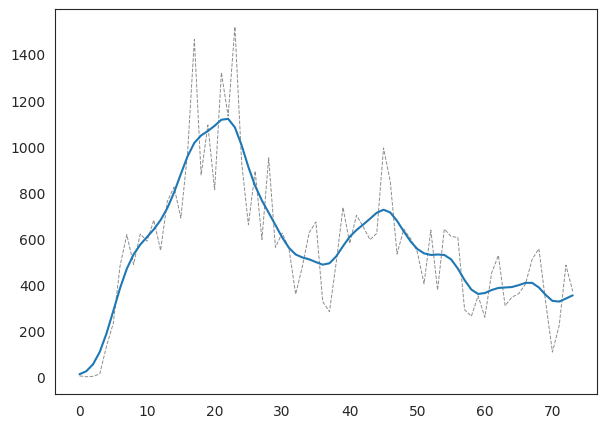

In [ ]:
from scipy.ndimage import gaussian_filter1d
y_pos = np.arange(len(df_affection['date']))
Final_array_smooth = gaussian_filter1d(df_affection['count'], sigma=2)

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(y_pos, df_affection['count'], '--', linewidth=0.7, color='k', alpha=0.45)
ax.plot(y_pos, Final_array_smooth)

## 4.2. Load Parameters

In [ ]:
df_parameters = pd.read_excel('Parameters.xlsx', sheet_name='Parameters')
df_parameters.head()

,Emotion,Model,S1,I1,b,k1,tau,lamb,error,R0,exp,inf,imn
0,Affection,SIR,1610.20872,6.000000,0.000312,0.034243,NaN,NaN,1952.431740,14.65,NaN,29.202708,NaN
1,Affection,SIRS,1932.72191,5.414357,0.000277,0.079261,31.655216,NaN,1761.590777,6.75,NaN,12.616542,31.655216
2,Affection,SEIR,1215.79453,2.486412,0.007585,0.021363,NaN,5.795128,1638.709583,431.64,5.795128,46.809072,NaN
3,Affection,SEIRS,1949.60703,1.026597,0.008003,0.120828,10.878114,8.179190,2084.492774,129.13,8.179190,8.276214,10.878114
4,Anger,SIR,1610.20864,2.000000,0.000185,0.074042,NaN,NaN,2089.165692,4.01,NaN,13.505760,NaN


## 4.3. Parameter Loader and Simulator

In [ ]:
S0 = int(df_describe['viewCount'].iloc[6]) # Sum of all views during that period

In [ ]:
def param_loader(
    emotion:str,
    model: str,
    df: pd.DataFrame,
    lamb: bool = False,
    tau: bool = False
    ):

    # Parameters
    df_subset = df_parameters.loc[(df_parameters['Emotion']==emotion) & (df_parameters['Model']==model)]

    params = lmfit.Parameters()
    params.add("S1", value=df_subset['S1'].values[0], min=S0/1000000, max=S0)
    params.add("I1", value=df_subset['I1'].values[0], min=1, max=int(df["count"].iloc[0]))  # No. of comments on first day
    params.add("b", value=df_subset['b'].values[0], min=0, max=1)
    params.add("k1", value=df_subset['k1'].values[0], min=0, max=1)

    if lamb:
      params.add("lambd", value=df_subset['lamb'].values[0], min=1, max=int(max(df.index)*0.5))

    if tau:
      params.add("tau", value=df_subset['tau'].values[0], min=1, max=int(max(df.index)*0.5))

    return params

In [ ]:
def simulator(
    df,     # Time Dimension
    p,      # Parameters
    model,  # Model Definition
    toFit,  # Parameter Names
    ):

    # Load model definition
    m = te.loada(model)

    # Load parameters
    pp = p.valuesdict()

    # Time dimension and Counts
    T = df.index

    # Loop through parameters to get values
    nParameters = len(toFit)
    for i in range(nParameters):
      m.model[toFit[i]] = pp[toFit[i]]

    # Simulation
    s = m.simulate(int(T[0]), int(T[-1]), len(T)*10, ['time', 'I1'])

    return s

In [ ]:
def plotter_indiv(
    df_original: pd.DataFrame,
    models: list,
    title: str,
    legend: bool = False,
    xlabel: str = ' ',
    ylabel: str = ' ',
    width = 3.1,
    height = 2.5
    ):

    plt.clf()
    fig, ax = plt.subplots(layout='constrained', figsize=(width,height))
    ax.plot(np.arange(len(df_original['date'])), df_original['count'], '--', color='k', alpha=0.45, label='Data')

    for i, j in zip(range(0,len(models)), ['SIR', 'SIRS', 'SEIR', 'SEIRS']):
      ax.plot(models[i]['time'], models[i]['I1'], label=j)

    if legend:
      #fig.legend(loc='outside center right')
      fig.legend(loc='outside upper center', bbox_transform=fig.transFigure, ncol=5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

## 4.4. Models

In [ ]:
SIR_model = '''
  // Equations
  E1: S1 -> I1 ; b * I1 * S1 ;
  E2: I1 -> R1 ; k1 * I1 ;

  // Parameters
  b = 2 ;
  k1 = 0.5 ;

 // Initial Conditions
  S1 = 1 ;
  I1 = 0.00001 ;
  R1 = 0.0 ;
'''

In [ ]:
SIRS_model = '''
  // Equations
  E1: S1 -> I1 ; b * I1 * S1 ;
  E2: I1 -> R1 ; k1 * I1 ;
  E3: R1 -> S1 ; R1/tau ;

  // Parameters
  b = 0.0002;
  k1 = 0.05 ;
  tau = 10 ;

 // Initial Conditions
  S0 = 150000000 ;
  I1 = 1 ;
  S1 = S0 - I1;
  R1 = 0 ;
'''

In [ ]:
SEIR_model = '''
  // Equations
  E1: S1 -> X1 ; b * I1 * S1;
  E2: X1 -> I1 ; X1 / lambd ;
  E3: I1 -> R1 ; k1 * I1 ;

  // Parameters
  b = 0.0002;
  k1 = 0.05 ;
  lambd = 10 ;

 // Initial Conditions
  S0 = 150000000 ;
  I1 = 1 ;
  S1 = S0 - I1;
  X1 = 0 ;
  R1 = 0 ;
'''

In [ ]:
SEIRS_model = '''
  // Equations
  E1: S1 -> X1 ; b * I1 * S1;
  E2: X1 -> I1 ; X1 / lambd ;
  E3: I1 -> R1 ; k1 * I1 ;
  E4: R1 -> S1 ; R1 / tau ;

  // Parameters
  b = 0.0002;
  k1 = 0.05 ;
  lambd = 10 ;
  tau = 10 ;

 // Initial Conditions
  S0 = 150000000 ;
  I1 = 1 ;
  S1 = S0 - I1;
  X1 = 0 ;
  R1 = 0 ;
'''

---
# 5. Emotions

## 5.1. Affection

In [ ]:
# Parameters
## SIR
SIR_toFit = ["S1", "I1", 'b', 'k1']
SIR_params_affection = param_loader('Affection', 'SIR', df_affection)

## SIRS
SIRS_toFit = ["S1", "I1", 'b', 'k1', 'tau']
SIRS_params_affection = param_loader('Affection', 'SIRS', df_affection, tau=True)

## SEIR
SEIR_toFit = ["S1", "I1", 'b', 'k1', 'lambd']
SEIR_params_affection = param_loader('Affection', 'SEIR', df_affection, lamb=True)

## SEIRS
SEIRS_toFit = ["S1", "I1", 'b', 'k1', 'lambd', 'tau']
SEIRS_params_affection = param_loader('Affection', 'SEIRS', df_affection, lamb=True, tau=True)

In [ ]:
SIR_affection = simulator(df_affection, SIR_params_affection, SIR_model, SIR_toFit)
SIRS_affection = simulator(df_affection, SIRS_params_affection, SIRS_model, SIRS_toFit)
SEIR_affection = simulator(df_affection, SEIR_params_affection, SEIR_model, SEIR_toFit)
SEIRS_affection = simulator(df_affection, SEIRS_params_affection, SEIRS_model, SEIRS_toFit)

<Figure size 1200x800 with 0 Axes>

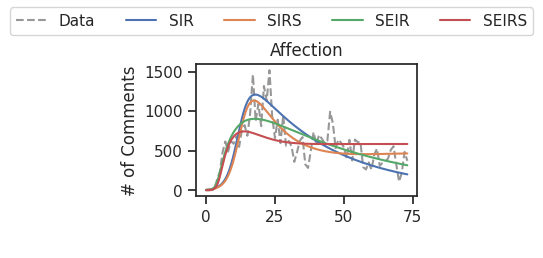

In [ ]:
plotter_indiv(df_affection, [SIR_affection, SIRS_affection, SEIR_affection, SEIRS_affection], title='Affection', ylabel='# of Comments', legend=True)

<Figure size 1200x800 with 0 Axes>

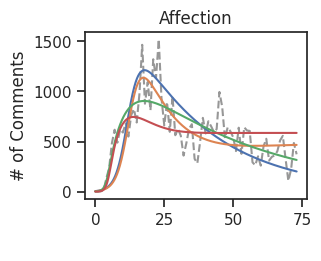

In [ ]:
plotter_indiv(df_affection, [SIR_affection, SIRS_affection, SEIR_affection, SEIRS_affection], title='Affection', ylabel='# of Comments')

## 5.2. Anger

In [ ]:
# Parameters
## SIR
SIR_toFit = ["S1", "I1", 'b', 'k1']
SIR_params_anger = param_loader('Anger', 'SIR', df_anger)

## SIRS
SIRS_toFit = ["S1", "I1", 'b', 'k1', 'tau']
SIRS_params_anger = param_loader('Anger', 'SIRS', df_anger, tau=True)

## SEIR
SEIR_toFit = ["S1", "I1", 'b', 'k1', 'lambd']
SEIR_params_anger = param_loader('Anger', 'SEIR', df_anger, lamb=True)

## SEIRS
SEIRS_toFit = ["S1", "I1", 'b', 'k1', 'lambd', 'tau']
SEIRS_params_anger = param_loader('Anger', 'SEIRS', df_anger, lamb=True, tau=True)

In [ ]:
SIR_anger = simulator(df_anger, SIR_params_anger, SIR_model, SIR_toFit)
SIRS_anger = simulator(df_anger, SIRS_params_anger, SIRS_model, SIRS_toFit)
SEIR_anger = simulator(df_anger, SEIR_params_anger, SEIR_model, SEIR_toFit)
SEIRS_anger = simulator(df_anger, SEIRS_params_anger, SEIRS_model, SEIRS_toFit)

<Figure size 1200x800 with 0 Axes>

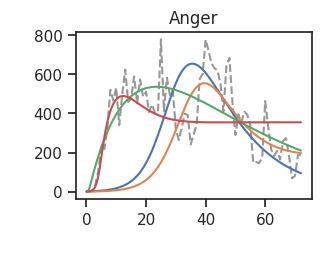

In [ ]:
plotter_indiv(df_anger, [SIR_anger, SIRS_anger, SEIR_anger, SEIRS_anger], title='Anger')

## 5.3. Contempt

In [ ]:
# Parameters
## SIR
SIR_toFit = ["S1", "I1", 'b', 'k1']
SIR_params_contempt = param_loader('Contempt', 'SIR', df_contempt)

## SIRS
SIRS_toFit = ["S1", "I1", 'b', 'k1', 'tau']
SIRS_params_contempt = param_loader('Contempt', 'SIRS', df_contempt, tau=True)

## SEIR
SEIR_toFit = ["S1", "I1", 'b', 'k1', 'lambd']
SEIR_params_contempt = param_loader('Contempt', 'SEIR', df_contempt, lamb=True)

## SEIRS
SEIRS_toFit = ["S1", "I1", 'b', 'k1', 'lambd', 'tau']
SEIRS_params_contempt = param_loader('Contempt', 'SEIRS', df_contempt, lamb=True, tau=True)

In [ ]:
SIR_contempt = simulator(df_contempt, SIR_params_contempt, SIR_model, SIR_toFit)
SIRS_contempt = simulator(df_contempt, SIRS_params_contempt, SIRS_model, SIRS_toFit)
SEIR_contempt = simulator(df_contempt, SEIR_params_contempt, SEIR_model, SEIR_toFit)
SEIRS_contempt = simulator(df_contempt, SEIRS_params_contempt, SEIRS_model, SEIRS_toFit)

<Figure size 1200x800 with 0 Axes>

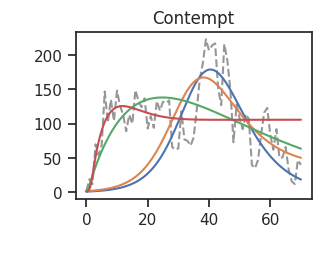

In [ ]:
plotter_indiv(df_contempt, [SIR_contempt, SIRS_contempt, SEIR_contempt, SEIRS_contempt], title='Contempt')

## 5.4. Depression

In [ ]:
# Parameters
## SIR
SIR_toFit = ["S1", "I1", 'b', 'k1']
SIR_params_depression = param_loader('Depression', 'SIR', df_depression)

## SIRS
SIRS_toFit = ["S1", "I1", 'b', 'k1', 'tau']
SIRS_params_depression = param_loader('Depression', 'SIRS', df_depression, tau=True)

## SEIR
SEIR_toFit = ["S1", "I1", 'b', 'k1', 'lambd']
SEIR_params_depression = param_loader('Depression', 'SEIR', df_depression, lamb=True)

## SEIRS
SEIRS_toFit = ["S1", "I1", 'b', 'k1', 'lambd', 'tau']
SEIRS_params_depression = param_loader('Depression', 'SEIRS', df_depression, lamb=True, tau=True)

In [ ]:
SIR_depression = simulator(df_depression, SIR_params_depression, SIR_model, SIR_toFit)
SIRS_depression = simulator(df_depression, SIRS_params_depression, SIRS_model, SIRS_toFit)
SEIR_depression = simulator(df_depression, SEIR_params_depression, SEIR_model, SEIR_toFit)
SEIRS_depression = simulator(df_depression, SEIRS_params_depression, SEIRS_model, SEIRS_toFit)

<Figure size 1200x800 with 0 Axes>

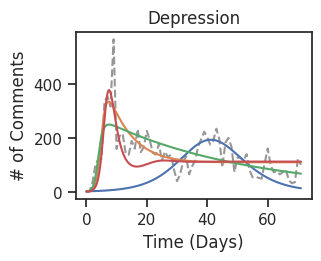

In [ ]:
plotter_indiv(df_depression, [SIR_depression, SIRS_depression, SEIR_depression, SEIRS_depression], title='Depression', ylabel = '# of Comments', xlabel = 'Time (Days)')

## 5.5. Fear

In [ ]:
# Parameters
## SIR
SIR_toFit = ["S1", "I1", 'b', 'k1']
SIR_params_fear = param_loader('Fear', 'SIR', df_fear)

## SIRS
SIRS_toFit = ["S1", "I1", 'b', 'k1', 'tau']
SIRS_params_fear = param_loader('Fear', 'SIRS', df_fear, tau=True)

## SEIR
SEIR_toFit = ["S1", "I1", 'b', 'k1', 'lambd']
SEIR_params_fear = param_loader('Fear', 'SEIR', df_fear, lamb=True)

## SEIRS
SEIRS_toFit = ["S1", "I1", 'b', 'k1', 'lambd', 'tau']
SEIRS_params_fear = param_loader('Fear', 'SEIRS', df_fear, lamb=True, tau=True)

In [ ]:
SIR_fear = simulator(df_fear, SIR_params_fear, SIR_model, SIR_toFit)
SIRS_fear = simulator(df_fear, SIRS_params_fear, SIRS_model, SIRS_toFit)
SEIR_fear = simulator(df_fear, SEIR_params_fear, SEIR_model, SEIR_toFit)
SEIRS_fear = simulator(df_fear, SEIRS_params_fear, SEIRS_model, SEIRS_toFit)

<Figure size 1200x800 with 0 Axes>

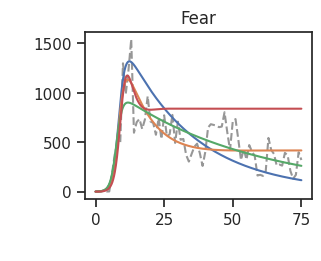

In [ ]:
plotter_indiv(df_fear, [SIR_fear, SIRS_fear, SEIR_fear, SEIRS_fear], title='Fear')

## 5.6. Happiness

In [ ]:
# Parameters
## SIR
SIR_toFit = ["S1", "I1", 'b', 'k1']
SIR_params_happiness = param_loader('Happiness', 'SIR', df_happiness)

## SIRS
SIRS_toFit = ["S1", "I1", 'b', 'k1', 'tau']
SIRS_params_happiness = param_loader('Happiness', 'SIRS', df_happiness, tau=True)

## SEIR
SEIR_toFit = ["S1", "I1", 'b', 'k1', 'lambd']
SEIR_params_happiness = param_loader('Happiness', 'SEIR', df_happiness, lamb=True)

## SEIRS
SEIRS_toFit = ["S1", "I1", 'b', 'k1', 'lambd', 'tau']
SEIRS_params_happiness = param_loader('Happiness', 'SEIRS', df_happiness, lamb=True, tau=True)

In [ ]:
SIR_happiness = simulator(df_happiness, SIR_params_happiness, SIR_model, SIR_toFit)
SIRS_happiness = simulator(df_happiness, SIRS_params_happiness, SIRS_model, SIRS_toFit)
SEIR_happiness = simulator(df_happiness, SEIR_params_happiness, SEIR_model, SEIR_toFit)
SEIRS_happiness = simulator(df_happiness, SEIRS_params_happiness, SEIRS_model, SEIRS_toFit)

<Figure size 1200x800 with 0 Axes>

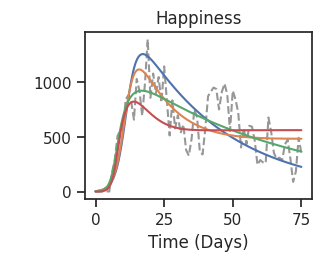

In [ ]:
plotter_indiv(df_happiness, [SIR_happiness, SIRS_happiness, SEIR_happiness, SEIRS_happiness], title='Happiness', xlabel = 'Time (Days)')

## 5.7. Satisfaction

In [ ]:
# Parameters
## SIR
SIR_toFit = ["S1", "I1", 'b', 'k1']
SIR_params_satisfaction = param_loader('Satisfaction', 'SIR', df_satisfaction)

## SIRS
SIRS_toFit = ["S1", "I1", 'b', 'k1', 'tau']
SIRS_params_satisfaction = param_loader('Satisfaction', 'SIRS', df_satisfaction, tau=True)

## SEIR
SEIR_toFit = ["S1", "I1", 'b', 'k1', 'lambd']
SEIR_params_satisfaction = param_loader('Satisfaction', 'SEIR', df_satisfaction, lamb=True)

## SEIRS
SEIRS_toFit = ["S1", "I1", 'b', 'k1', 'lambd', 'tau']
SEIRS_params_satisfaction = param_loader('Satisfaction', 'SEIRS', df_satisfaction, lamb=True, tau=True)

In [ ]:
SIR_satisfaction = simulator(df_satisfaction, SIR_params_satisfaction, SIR_model, SIR_toFit)
SIRS_satisfaction = simulator(df_satisfaction, SIRS_params_satisfaction, SIRS_model, SIRS_toFit)
SEIR_satisfaction = simulator(df_satisfaction, SEIR_params_satisfaction, SEIR_model, SEIR_toFit)
SEIRS_satisfaction = simulator(df_satisfaction, SEIRS_params_satisfaction, SEIRS_model, SEIRS_toFit)

<Figure size 1200x800 with 0 Axes>

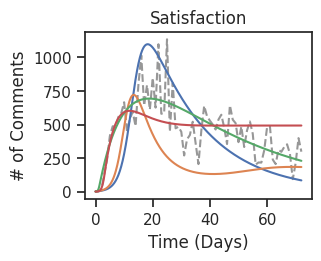

In [ ]:
plotter_indiv(df_satisfaction, [SIR_satisfaction, SIRS_satisfaction, SEIR_satisfaction, SEIRS_satisfaction],
              title='Satisfaction', ylabel = '# of Comments', xlabel = 'Time (Days)')

# 6. All Emotions

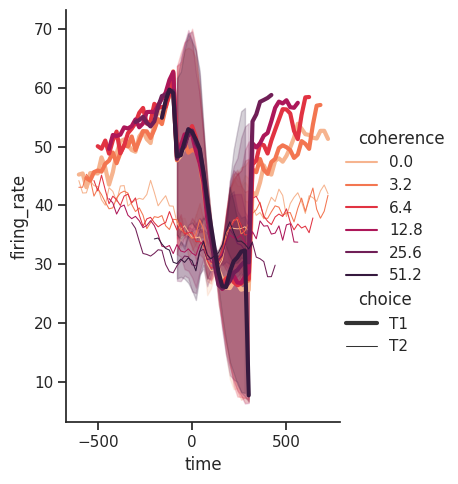

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks")

dots = sns.load_dataset("dots")

# Define the palette as a list to specify exact values
palette = sns.color_palette("rocket_r")

# Plot the lines on two facets
sns.relplot(
    data=dots,
    x="time", y="firing_rate",
    hue="coherence", size="choice", col="align",
    kind="line", size_order=["T1", "T2"], palette=palette,
    height=5, aspect=.75, facet_kws={'sharex': 'col'}
)